# Data Analytics Graduate Capstone — D214
## by Renzo Espinoza

## Research Question

Is there a statistically significant relationship between the walkability of a county in the United States and the prevalence of chronic illnesses in that area?

## Data Collection

Medicare Chronic Conditions Dashboard - https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Chronic-Conditions/CCDashboard

U.S. EPA National Walkability Index - https://catalog.data.gov/dataset/walkability-index

## Data Extraction and Preparation

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm

In [105]:
prevalence = pd.read_excel('datasets/medicare_dashboard_2018.xlsx', sheet_name='Prevalence')

In [106]:
prevalence

,State,County,Chronic Conditions,Count of Beneficiaries in County,Chronic Condition Prevalence (%)
0,National,National,Alcohol Abuse,33503234.0,2.0793
1,National,National,Alzheimer's Disease/Dementia,33503234.0,10.7782
2,National,National,Arthritis,33503234.0,33.4688
3,National,National,Asthma,33503234.0,4.9723
4,National,National,Atrial Fibrillation,33503234.0,8.4052
...,...,...,...,...,...
68266,Unknown,Unknown,Hypertension,NaN,NaN
68267,Unknown,Unknown,Ischemic Heart Disease,NaN,NaN
68268,Unknown,Unknown,Osteoporosis,NaN,NaN
68269,Unknown,Unknown,Schizophrenia and Other Psychotic Disorders,NaN,NaN


In [107]:
prevalence.rename(columns={'Chronic Conditions': 'ChronicConditions',
                          'Count of Beneficiaries in County': 'Beneficiaries',
                          'Chronic Condition Prevalence (%)': 'Prevalence'},
                 inplace=True)

In [108]:
prevalence.ChronicConditions.unique()

array(['Alcohol Abuse', "Alzheimer's Disease/Dementia", 'Arthritis',
       'Asthma', 'Atrial Fibrillation', 'Autism Spectrum Disorders',
       'COPD', 'Cancer', 'Chronic Kidney Disease', 'Depression',
       'Diabetes', 'Drug/Substance Abuse', 'HIV/AIDS', 'Heart Failure',
       'Hepatitis (Chronic Viral B & C)', 'Hyperlipidemia',
       'Hypertension', 'Ischemic Heart Disease', 'Osteoporosis',
       'Schizophrenia and Other Psychotic Disorders', 'Stroke'],
      dtype=object)

In [109]:
prevalence.isnull().sum()

State                   0
County                  0
ChronicConditions       0
Beneficiaries        1071
Prevalence           6216
dtype: int64

In [110]:
prevalence.dropna(inplace=True)

In [111]:
prevalence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62055 entries, 0 to 68249
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              62055 non-null  object 
 1   County             62055 non-null  object 
 2   ChronicConditions  62055 non-null  object 
 3   Beneficiaries      62055 non-null  float64
 4   Prevalence         62055 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.8+ MB


In [112]:
spending = pd.read_excel('datasets/medicare_dashboard_2018.xlsx', sheet_name='Spending and Utilization')

In [113]:
spending

,State,County,Number of Chronic Conditions,Count of Beneficiaries in County,Prevalence (%),Per Capita Medicare Spending ($),"ED Visits per 1,000 Beneficiaries",30 Day Readmission Rate (%)
0,National,National,0 to 1,10416133,31.09,2061.2847,174.0199,0.0591
1,National,National,2 to 3,9741510,29.08,5843.5271,400.7496,0.0755
2,National,National,4 to 5,7415816,22.13,11036.0516,726.4933,0.1072
3,National,National,6+,5929775,17.70,30118.6940,1922.2156,0.2270
4,Alabama,Autauga,0 to 1,1338,26.58,2205.6662,210.7623,NaN
...,...,...,...,...,...,...,...,...
12999,Wyoming,State,6+,9060,9.42,32474.0427,2302.5386,0.2079
13000,Unknown,Unknown,0 to 1,47002,NaN,NaN,NaN,NaN
13001,Unknown,Unknown,2 to 3,5631,NaN,NaN,NaN,NaN
13002,Unknown,Unknown,4 to 5,3807,NaN,NaN,NaN,NaN


In [114]:
spending.rename(columns={'Number of Chronic Conditions': 'ChronicConditionAmount',
                          'Count of Beneficiaries in County': 'Beneficiaries',
                          'Prevalence (%)': 'Prevalence',
                          'Per Capita Medicare Spending ($)': 'PerCapitaMedicareSpending'},
                 inplace=True)

In [115]:
spending.isnull().sum()

State                                   0
County                                  0
ChronicConditionAmount                  0
Beneficiaries                           0
Prevalence                            248
PerCapitaMedicareSpending             248
ED Visits per 1,000 Beneficiaries     500
30 Day Readmission Rate (%)          5148
dtype: int64

In [116]:
spending.drop(spending.columns[[6,7]], axis=1, inplace=True)

In [117]:
spending.dropna(inplace=True)

In [118]:
spending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12756 entries, 0 to 12999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      12756 non-null  object 
 1   County                     12756 non-null  object 
 2   ChronicConditionAmount     12756 non-null  object 
 3   Beneficiaries              12756 non-null  int64  
 4   Prevalence                 12756 non-null  float64
 5   PerCapitaMedicareSpending  12756 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 697.6+ KB


In [119]:
condition = spending[(spending.County == 'State') | (spending.County == 'National')].index
spending.drop(condition, inplace=True)

In [120]:
condition = prevalence[(prevalence.County == 'State') | (prevalence.County == 'National')].index
prevalence.drop(condition, inplace=True)

In [121]:
walkability = pd.read_csv('datasets/epa_walkability_jan_2021.csv')

In [122]:
walkability

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,...,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
0,1,4.811300e+11,4.811300e+11,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.184697,0.000476,0.137707,6,14,15,17,14.000000,3110.360820,2.978361e+05
1,2,4.811300e+11,4.811300e+11,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.323221,0.000801,0.231868,3,10,12,14,10.833333,3519.469110,4.849451e+05
2,3,4.811300e+11,4.811300e+11,48,113,7825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.314628,0.000736,0.213146,1,1,7,17,8.333333,1697.091802,1.067059e+05
3,4,4.811300e+11,4.811300e+11,48,113,7824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.229821,0.000708,0.205018,16,10,17,17,15.666667,2922.609204,4.818284e+05
4,5,4.811300e+11,4.811300e+11,48,113,7824,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,...,0.164863,0.000433,0.125296,4,7,11,14,10.166667,3731.971773,6.876848e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220735,220736,7.803100e+11,7.803100e+11,78,30,961000,2,NaN,NaN,NaN,...,-99999.000000,-99999.000000,-99999.000000,1,1,20,1,7.333333,3414.446949,3.355857e+05
220736,220737,7.803100e+11,7.803100e+11,78,30,961000,3,NaN,NaN,NaN,...,-99999.000000,-99999.000000,-99999.000000,1,1,20,1,7.333333,2421.025608,2.924305e+05
220737,220738,7.803100e+11,7.803100e+11,78,30,961000,5,NaN,NaN,NaN,...,-99999.000000,-99999.000000,-99999.000000,1,1,20,1,7.333333,1955.909418,1.619395e+05
220738,220739,7.803100e+11,7.803100e+11,78,30,960700,3,NaN,NaN,NaN,...,-99999.000000,-99999.000000,-99999.000000,1,1,10,1,4.000000,16896.768870,1.038966e+07


In [123]:
print('Unique Combined Statistical Areas in EPA dataset:')
print(len(walkability.CSA_Name.unique()))

Unique Combined Statistical Areas in EPA dataset:
176


In [124]:
print('Unique counties in CMS dataset:')
print(len(spending.County.unique().tolist()))

Unique counties in CMS dataset:
1846


In [125]:
walkability.STATEFP = walkability.STATEFP.astype('str')
walkability.COUNTYFP = walkability.COUNTYFP.astype('str')

In [126]:
walkability.COUNTYFP = walkability.COUNTYFP.str.pad(3, fillchar='0')
walkability.COUNTYFP

0         113
1         113
2         113
3         113
4         113
         ... 
220735    030
220736    030
220737    030
220738    030
220739    030
Name: COUNTYFP, Length: 220740, dtype: object

In [127]:
walkability['fips'] = walkability.STATEFP + walkability.COUNTYFP

In [131]:
null_walk = walkability.isnull().sum()
for key,value in null_walk.iteritems():
    print(key,value)

OBJECTID 0
GEOID10 1
GEOID20 0
STATEFP 0
COUNTYFP 0
TRACTCE 0
BLKGRPCE 0
CSA 53031
CSA_Name 53031
CBSA 17095
CBSA_Name 17095
CBSA_POP 0
CBSA_EMP 0
CBSA_WRK 0
Ac_Total 0
Ac_Water 0
Ac_Land 0
Ac_Unpr 0
TotPop 0
CountHU 275
HH 275
P_WrkAge 0
AutoOwn0 0
Pct_AO0 0
AutoOwn1 0
Pct_AO1 0
AutoOwn2p 0
Pct_AO2p 0
Workers 0
R_LowWageWk 0
R_MedWageWk 0
R_HiWageWk 0
R_PCTLOWWAGE 0
TotEmp 0
E5_Ret 0
E5_Off 0
E5_Ind 0
E5_Svc 0
E5_Ent 0
E8_Ret 0
E8_off 0
E8_Ind 0
E8_Svc 0
E8_Ent 0
E8_Ed 0
E8_Hlth 0
E8_Pub 0
E_LowWageWk 0
E_MedWageWk 0
E_HiWageWk 0
E_PctLowWage 0
D1A 271
D1B 0
D1C 0
D1C5_RET 0
D1C5_OFF 0
D1C5_IND 0
D1C5_SVC 0
D1C5_ENT 0
D1C8_RET 0
D1C8_OFF 605
D1C8_IND 0
D1C8_SVC 0
D1C8_ENT 0
D1C8_ED 0
D1C8_HLTH 0
D1C8_PUB 0
D1D 0
D1_FLAG 0
D2A_JPHH 0
D2B_E5MIX 0
D2B_E5MIXA 0
D2B_E8MIX 0
D2B_E8MIXA 0
D2A_EPHHM 0
D2C_TRPMX1 0
D2C_TRPMX2 0
D2C_TRIPEQ 0
D2R_JOBPOP 0
D2R_WRKEMP 0
D2A_WRKEMP 0
D2C_WREMLX 0
D3A 0
D3AAO 0
D3AMM 0
D3APO 0
D3B 0
D3BAO 0
D3BMM3 0
D3BMM4 0
D3BPO3 0
D3BPO4 0
D4A 0
D4B025 0
D4B050 0

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\827094522.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key,value in null_walk.iteritems():


In [26]:
# filtering dataframe to contain only features that I am interested in
walkability = walkability[['fips', 'NatWalkInd','TotPop',
                           'D1A', 'D1B', 'D1C','R_PCTLOWWAGE']]

In [27]:
walkability

,fips,NatWalkInd,TotPop,D1A,D1B,D1C,R_PCTLOWWAGE
0,48113,14.000000,1202,6.250422,16.332625,0.896800,0.240291
1,48113,10.833333,710,3.430799,5.955666,0.209707,0.192405
2,48113,8.333333,737,13.843035,27.951553,0.000000,0.293737
3,48113,15.666667,904,3.225246,7.592767,2.124967,0.139211
4,48113,10.166667,948,2.305992,6.373413,0.215136,0.157168
...,...,...,...,...,...,...,...
220735,78030,7.333333,1471,8.761019,18.813808,0.000000,0.000000
220736,78030,7.333333,940,8.040306,13.008412,0.000000,0.000000
220737,78030,7.333333,878,12.545333,21.941838,0.000000,0.000000
220738,78030,4.000000,1278,1.404107,1.485471,0.000000,0.000000


In [28]:
walkability.isnull().sum()

fips              0
NatWalkInd        0
TotPop            0
D1A             271
D1B               0
D1C               0
R_PCTLOWWAGE      0
dtype: int64

In [29]:
walkability[walkability['D1A'].isna()]

,fips,NatWalkInd,TotPop,D1A,D1B,D1C,R_PCTLOWWAGE
217783,66010,1.0,1223,NaN,15.933417,0.0,0.0
217784,66010,1.0,999,NaN,7.526249,0.0,0.0
217785,66010,1.0,525,NaN,16.584285,0.0,0.0
217786,66010,1.0,640,NaN,4.520495,0.0,0.0
217787,66010,1.0,682,NaN,7.517141,0.0,0.0
...,...,...,...,...,...,...,...
218052,69110,1.0,1700,NaN,2.523464,0.0,0.0
218053,69120,1.0,654,NaN,2.468680,0.0,0.0
218054,69120,1.0,0,NaN,0.000000,0.0,0.0
218055,69120,1.0,679,NaN,0.043336,0.0,0.0


In [30]:
walkability.dropna(inplace=True)

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\1058171967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walkability.dropna(inplace=True)


In [31]:
fips_codes = pd.read_csv('datasets/fips.csv')

In [32]:
fips_codes

,fips,name,state
0,0,UNITED STATES,NaN
1,1000,ALABAMA,NaN
2,1001,Autauga County,AL
3,1003,Baldwin County,AL
4,1005,Barbour County,AL
...,...,...,...
3190,56037,Sweetwater County,WY
3191,56039,Teton County,WY
3192,56041,Uinta County,WY
3193,56043,Washakie County,WY


In [33]:
fips_codes.isnull().sum()

fips      0
name      0
state    52
dtype: int64

In [34]:
fips_codes.dropna(inplace=True)

In [35]:
state_initials = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [36]:
spending.State = spending.State.map(lambda x: state_initials.get(x, x))

In [37]:
spending.State

4        AL
5        AL
6        AL
7        AL
8        AL
         ..
12991    WY
12992    WY
12993    WY
12994    WY
12995    WY
Name: State, Length: 12548, dtype: object

In [38]:
prevalence.State = prevalence.State.map(lambda x: state_initials.get(x, x))

In [39]:
spending.describe()

,Beneficiaries,Prevalence,PerCapitaMedicareSpending
count,12548.000000,12548.000000,12548.000000
mean,2654.748406,24.936246,12390.364206
std,6255.741635,7.878396,11074.722260
min,0.000000,0.000000,0.000000
25%,420.000000,19.830000,3397.853175
50%,947.000000,24.920000,8555.194100
75%,2310.250000,29.490000,20436.586400
max,169367.000000,62.700000,83448.042700


In [40]:
prevalence.describe()

,Beneficiaries,Prevalence
count,60963.000000,60963.000000
mean,11270.489067,15.556019
std,25141.223727,15.761536
min,0.000000,0.000000
25%,1951.000000,3.523800
50%,4131.000000,9.366700
75%,10382.000000,23.963400
max,574603.000000,81.250000


In [41]:
walkability.describe()

,NatWalkInd,TotPop,D1A,D1B,D1C,R_PCTLOWWAGE
count,220469.000000,220469.000000,220469.000000,220469.000000,220469.000000,220469.000000
mean,9.552128,1480.715633,4.530262,10.435181,3.778251,0.234803
std,4.366369,988.005821,13.881912,29.146521,46.420755,0.061955
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.833333,890.000000,0.300543,0.714523,0.076639,0.202267
50%,9.166667,1266.000000,1.845611,4.322434,0.535558,0.232078
75%,13.333333,1816.000000,4.163989,10.140896,2.161322,0.266589
max,20.000000,55407.000000,1481.257220,3133.578265,14032.760640,1.000000


In [42]:
grouped = walkability.groupby('fips').agg({'NatWalkInd': 'median', 'TotPop': 'sum', 
                                 'D1A': 'median', 'D1B': 'median', 'D1C': 'median',
                                 'R_PCTLOWWAGE': 'mean',
                                          })

In [43]:
grouped = grouped.reset_index()

In [44]:
grouped.rename(columns={'D1A': 'ResidentialDensity',
                       'D1B': 'PopulationDensity',
                       'D1C': 'EmploymentDensity',
                       'R_PCTLOWWAGE': 'PctLowWage'}, inplace=True)

In [45]:
grouped

,fips,NatWalkInd,TotPop,ResidentialDensity,PopulationDensity,EmploymentDensity,PctLowWage
0,10001,6.833333,174822,0.420903,1.098827,0.141083,0.244124
1,10003,12.666667,555133,2.635021,6.729338,1.438479,0.235815
2,10005,7.166667,219540,0.648872,0.807456,0.139455,0.266264
3,1001,4.666667,55200,0.263939,0.628581,0.076586,0.230803
4,1003,6.250000,208107,0.334766,0.605024,0.110535,0.242640
...,...,...,...,...,...,...,...
3227,9007,7.833333,163368,0.528549,1.037497,0.301029,0.195666
3228,9009,12.166667,859339,2.448542,5.715410,0.820786,0.229553
3229,9011,8.250000,268881,0.635066,1.379954,0.296703,0.218712
3230,9013,6.166667,151269,0.260281,0.640312,0.112072,0.197252


In [46]:
print('Unique counties in CMS dataset:')
print(len(spending.County.unique().tolist()))

Unique counties in CMS dataset:
1846


In [47]:
fips_codes.name.replace(' County', '', regex=True, inplace=True)

In [48]:
grouped.fips = grouped.fips.astype('int64')

In [49]:
walkability = pd.merge(grouped, fips_codes,  how='left', left_on=['fips'], right_on = ['fips'])

In [50]:
walkability

,fips,NatWalkInd,TotPop,ResidentialDensity,PopulationDensity,EmploymentDensity,PctLowWage,name,state
0,10001,6.833333,174822,0.420903,1.098827,0.141083,0.244124,Kent,DE
1,10003,12.666667,555133,2.635021,6.729338,1.438479,0.235815,New Castle,DE
2,10005,7.166667,219540,0.648872,0.807456,0.139455,0.266264,Sussex,DE
3,1001,4.666667,55200,0.263939,0.628581,0.076586,0.230803,Autauga,AL
4,1003,6.250000,208107,0.334766,0.605024,0.110535,0.242640,Baldwin,AL
...,...,...,...,...,...,...,...,...,...
3227,9007,7.833333,163368,0.528549,1.037497,0.301029,0.195666,Middlesex,CT
3228,9009,12.166667,859339,2.448542,5.715410,0.820786,0.229553,New Haven,CT
3229,9011,8.250000,268881,0.635066,1.379954,0.296703,0.218712,New London,CT
3230,9013,6.166667,151269,0.260281,0.640312,0.112072,0.197252,Tolland,CT


In [51]:
missing_counties = walkability.loc[walkability.name.isnull()]

In [52]:
display(missing_counties)

,fips,NatWalkInd,TotPop,ResidentialDensity,PopulationDensity,EmploymentDensity,PctLowWage,name,state
878,2158,4.833333,8198,0.001950,0.007102,0.000751,0.125000,NaN,NaN
2207,46102,3.666667,14335,0.004051,0.014163,0.002641,0.278732,NaN,NaN
3013,60010,1.000000,23030,0.354127,1.723508,0.000000,0.000000,NaN,NaN
3014,60020,1.000000,1143,0.038186,0.092613,0.000000,0.000000,NaN,NaN
3016,60030,1.000000,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3155,72151,2.833333,34149,0.475822,1.139685,0.000000,0.000000,NaN,NaN
3156,72153,4.833333,36439,1.716170,3.481300,0.000000,0.000000,NaN,NaN
3157,78010,4.000000,50601,0.879959,1.778464,0.000000,0.000000,NaN,NaN
3158,78020,3.166667,4170,1.020789,1.020874,0.000000,0.000000,NaN,NaN


In [53]:
spending_walkability = pd.merge(spending, walkability, how='left', left_on=['State', 'County'], right_on=['state', 'name'])

In [54]:
spending_walkability

,State,County,ChronicConditionAmount,Beneficiaries,Prevalence,PerCapitaMedicareSpending,fips,NatWalkInd,TotPop,ResidentialDensity,PopulationDensity,EmploymentDensity,PctLowWage,name,state
0,AL,Autauga,0 to 1,1338,26.58,2205.6662,1001.0,4.666667,55200.0,0.263939,0.628581,0.076586,0.230803,Autauga,AL
1,AL,Autauga,2 to 3,1416,28.13,5553.1539,1001.0,4.666667,55200.0,0.263939,0.628581,0.076586,0.230803,Autauga,AL
2,AL,Autauga,4 to 5,1249,24.81,10424.6752,1001.0,4.666667,55200.0,0.263939,0.628581,0.076586,0.230803,Autauga,AL
3,AL,Autauga,6+,1031,20.48,27300.1283,1001.0,4.666667,55200.0,0.263939,0.628581,0.076586,0.230803,Autauga,AL
4,AL,Baldwin,0 to 1,7222,27.66,2205.9072,1003.0,6.250000,208107.0,0.334766,0.605024,0.110535,0.242640,Baldwin,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12543,WY,Washakie,6+,175,9.92,40937.0233,56043.0,7.333333,8129.0,0.597772,1.507934,0.485411,0.260915,Washakie,WY
12544,WY,Weston,0 to 1,663,46.56,1995.1567,56045.0,5.666667,7100.0,0.039457,0.093379,0.015009,0.240944,Weston,WY
12545,WY,Weston,2 to 3,390,27.39,7390.8903,56045.0,5.666667,7100.0,0.039457,0.093379,0.015009,0.240944,Weston,WY
12546,WY,Weston,4 to 5,242,16.99,13631.4736,56045.0,5.666667,7100.0,0.039457,0.093379,0.015009,0.240944,Weston,WY


In [55]:
missing = spending_walkability.loc[spending_walkability.NatWalkInd.isnull()]
missing = missing.groupby(['State', 'County']).mean()

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\1317896272.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  missing = missing.groupby(['State', 'County']).mean()


In [56]:
with pd.option_context('display.max_rows', None):
    display(missing)

Beneficiaries  Prevalence  \
State County                                                 
AK    Aleutians East                     29.25     25.0000   
      Aleutians West                     33.75     25.0000   
      Anchorage                        7881.00     24.9975   
      Bethel                            308.00     25.0025   
      Bristol Bay                        29.25     25.0000   
      Dillingham                        101.50     25.0000   
      Fairbanks North Star             2623.00     25.0025   
      Haines                            135.50     25.0000   
      Hoonah-Angoon                      77.75     25.0000   
      Juneau                           1102.00     25.0025   
      Kenai Peninsula                  2582.75     25.0000   
      Ketchikan Gateway                 551.50     25.0025   
      Kodiak Island                     348.00     25.0000   
      Kusilvak                          118.25     25.0000   
      Lake and Peninsula                 37.00     25.0000   
      Matanuska-Susitna                3107.25     25.0025   
      Nome                              178.75     25.0000   
      North Slope                       103.50     25.0000   
      Northwest Arctic                  112.75     25.0000   
      Petersburg                        180.00     25.0000   
      Prince of Wales-Hyder             209.00     24.9975   
      Prince of Wales-Outer Ket           0.00      0.0000   
      Sitka                             314.25     25.0000   
      Skagway                            67.00     25.0025   
      Skagway-Hoonah-Angoon               0.00      0.0000   
      Southeast Fairbanks               273.75     25.0000   
      Valdez-Cordova                    312.25     25.0000   
      Wade Hampton                        0.00      0.0000   
      Wrangell                          117.50     25.0000   
      Wrangell-Petersburg                 0.00      0.0000   
      Yakutat                            26.00     25.0000   
      Yukon-Koyukuk                     177.25     25.0000   
IL    DeWitt                            637.00     25.0000   
LA    Acadia                           2201.25     25.0000   
      Allen                             917.25     25.0000   
      Ascension                        1566.25     25.0000   
      Assumption                        723.75     25.0025   
      Avoyelles                        1761.50     25.0000   
      Beauregard                       1432.00     24.9975   
      Bienville                         620.50     25.0000   
      Bossier                          3636.50     25.0025   
      Caddo                            8078.75     24.9975   
      Calcasieu                        6923.75     25.0000   
      Caldwell                          377.50     25.0025   
      Cameron                           216.50     25.0000   
      Catahoula                         419.50     25.0000   
      Claiborne                         640.25     25.0000   
      Concordia                         817.00     25.0025   
      DeSoto                           1119.00     25.0000   
      East Baton Rouge                 8124.75     24.9975   
      East Carroll                      230.25     25.0000   
      East Feliciana                    547.50     24.9975   
      Evangeline                       1482.75     25.0000   
      Franklin                          834.75     24.9975   
      Grant                             784.75     25.0000   
      Iberia                           2668.25     25.0000   
      Iberville                         610.00     25.0000   
      Jackson                           655.25     25.0000   
      Jefferson                        7064.00     25.0000   
      Jefferson Davis                  1248.75     25.0000   
      LaSalle                           592.50     25.0025   
      Lafayette                        6853.00     24.9975   
      Lafourche                        2876.50     25.0000   
   

In [57]:
filler = [
    ' City and Borough',
    ' Borough',
    ' Census Area',
    ' Municipality',
    ' Parish'
]
regex = '|'.join(filler)

In [58]:
fips_codes.name.replace(regex, '', regex=True, inplace=True)

In [59]:
fips_codes.name.replace('De Witt', 'DeWitt', inplace=True)

In [60]:
fips_codes.name.replace('La Salle', 'LaSalle', inplace=True)

In [61]:
fips_codes.name.replace('De Soto', 'DeSoto', inplace=True)

In [62]:
fips_codes.name.replace('city', 'City', inplace=True, regex=True)

In [63]:
fips_codes.name.replace('Do̱a', 'Dona', inplace=True, regex=True)

In [64]:
spending.County.replace('La Salle', 'LaSalle', inplace=True)

In [65]:
prevalence.County.replace('La Salle', 'LaSalle', inplace=True)

In [66]:
fips_codes.name.str.contains('Oglala').sum()

0

In [67]:
fips_codes.name.str.contains('Kusilvak').sum()

0

In [68]:
condition = spending[(spending['Beneficiaries'] == 0)
                     | (spending.County == 'Kusilvak')
                     | (spending.County == 'Oglala Lakota')].index
spending.drop(condition, inplace=True)

In [69]:
condition = prevalence[(prevalence['Beneficiaries'] == 0) 
                       | (prevalence.County == 'Kusilvak') 
                       | (prevalence.County == 'Oglala Lakota')].index
prevalence.drop(condition, inplace=True)

In [70]:
walkability = pd.merge(grouped, fips_codes,  how='left', left_on=['fips'], right_on = ['fips'])

In [71]:
spending_walkability = pd.merge(spending, walkability, how='left', left_on=['State', 'County'], right_on=['state', 'name'])

In [72]:
spending_walkability.drop(columns=['state', 'name'], inplace=True)

In [73]:
spending_walkability.isnull().sum()

State                        0
County                       0
ChronicConditionAmount       0
Beneficiaries                0
Prevalence                   0
PerCapitaMedicareSpending    0
fips                         0
NatWalkInd                   0
TotPop                       0
ResidentialDensity           0
PopulationDensity            0
EmploymentDensity            0
PctLowWage                   0
dtype: int64

In [74]:
walkability.rename(columns={'state': 'State',
                           'name': 'County'}, inplace=True)

In [75]:
walkability.to_csv('walkability_cleaned.csv')

In [76]:
spending.to_csv('spending_cleaned.csv')

In [77]:
prevalence.to_csv('prevalence_cleaned.csv')

## Analysis

In [78]:
sns.set_theme(style='darkgrid')
plt.rcParams['figure.dpi'] = 150
sns.set_palette('flare')

<Axes: xlabel='NatWalkInd', ylabel='Count'>

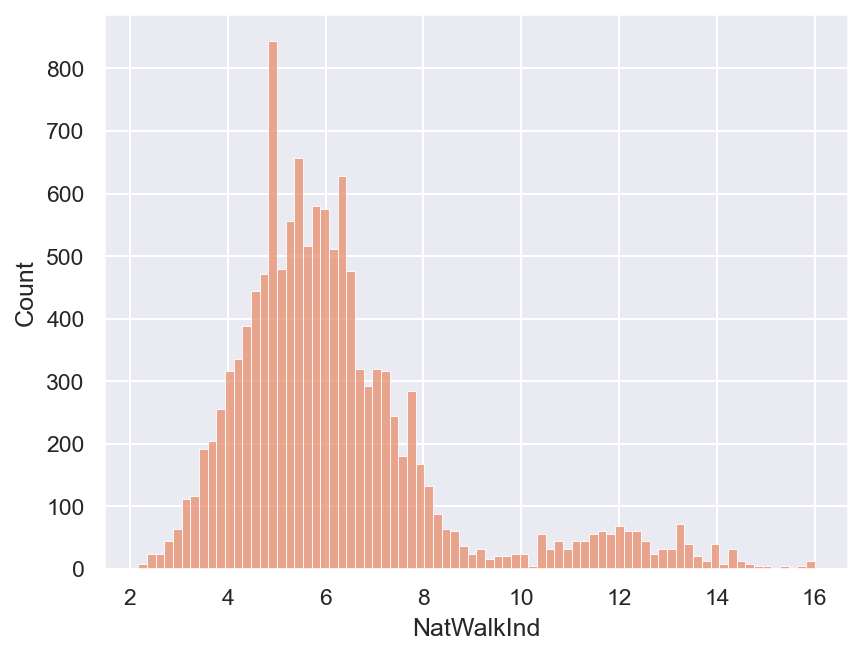

In [79]:
sns.histplot(spending_walkability, x='NatWalkInd')

In [80]:
log_walk = np.log(spending_walkability.NatWalkInd)

<Axes: xlabel='NatWalkInd', ylabel='Count'>

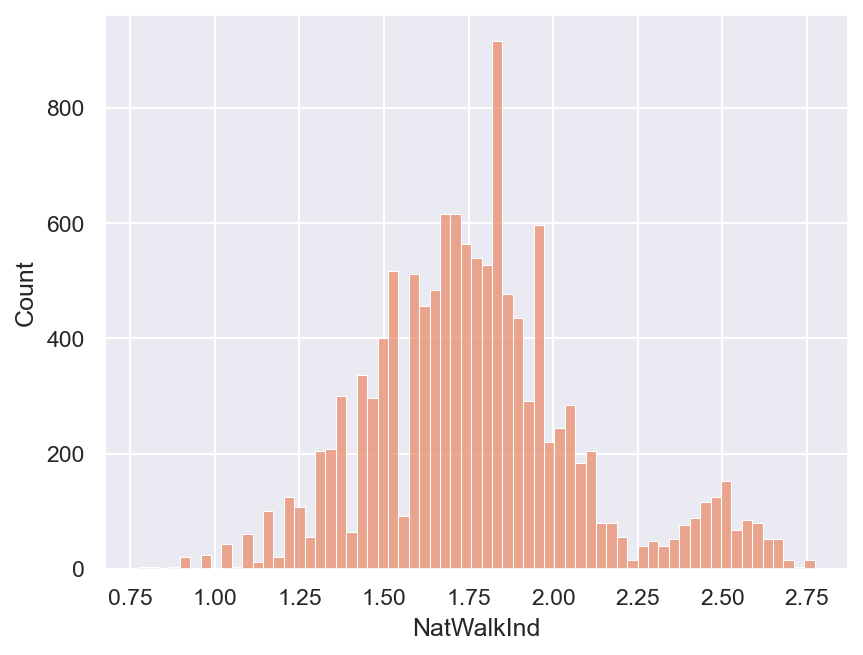

In [81]:
sns.histplot(log_walk)

In [82]:
spending_walkability.NatWalkInd = log_walk

<Axes: xlabel='ChronicConditionAmount', ylabel='Prevalence'>

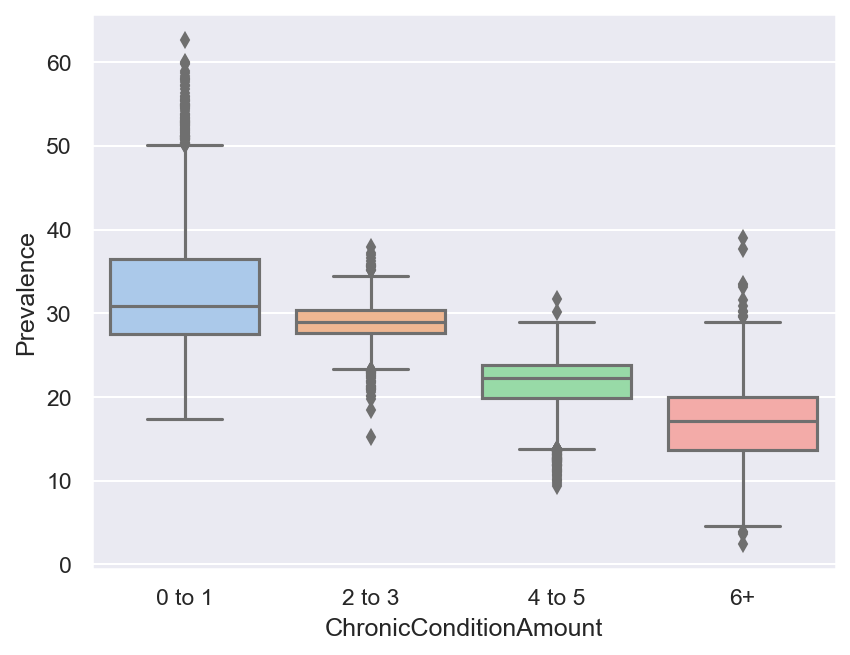

In [83]:
sns.boxplot(spending_walkability, y='Prevalence', x='ChronicConditionAmount', palette='pastel')

<Axes: xlabel='ChronicConditionAmount', ylabel='PerCapitaMedicareSpending'>

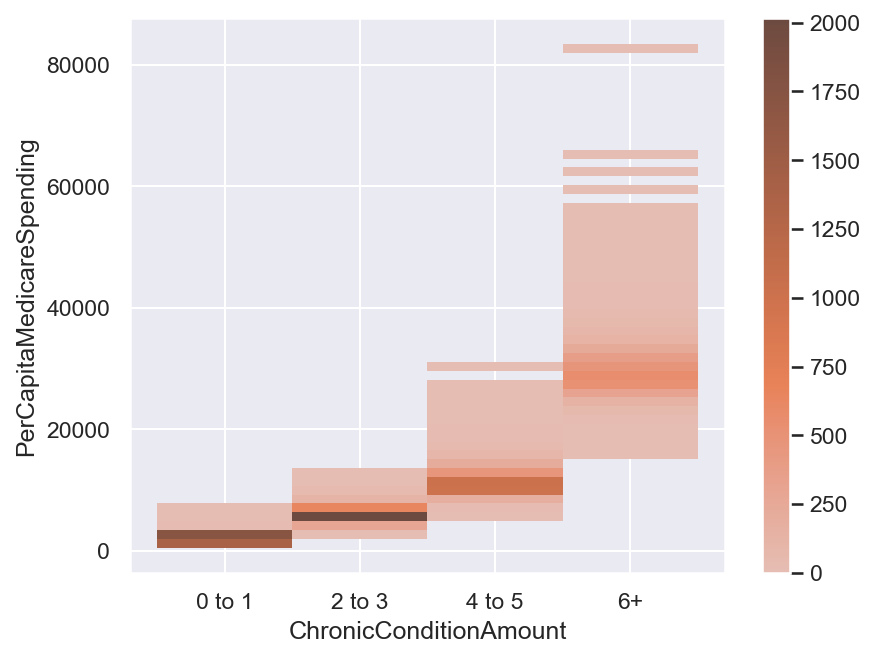

In [84]:
sns.histplot(spending_walkability, y='PerCapitaMedicareSpending', x='ChronicConditionAmount', cbar=True)

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\4234882986.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(zero_one.corr())


Text(0.5, 1.0, '0 to 1 Chronic Conditions')

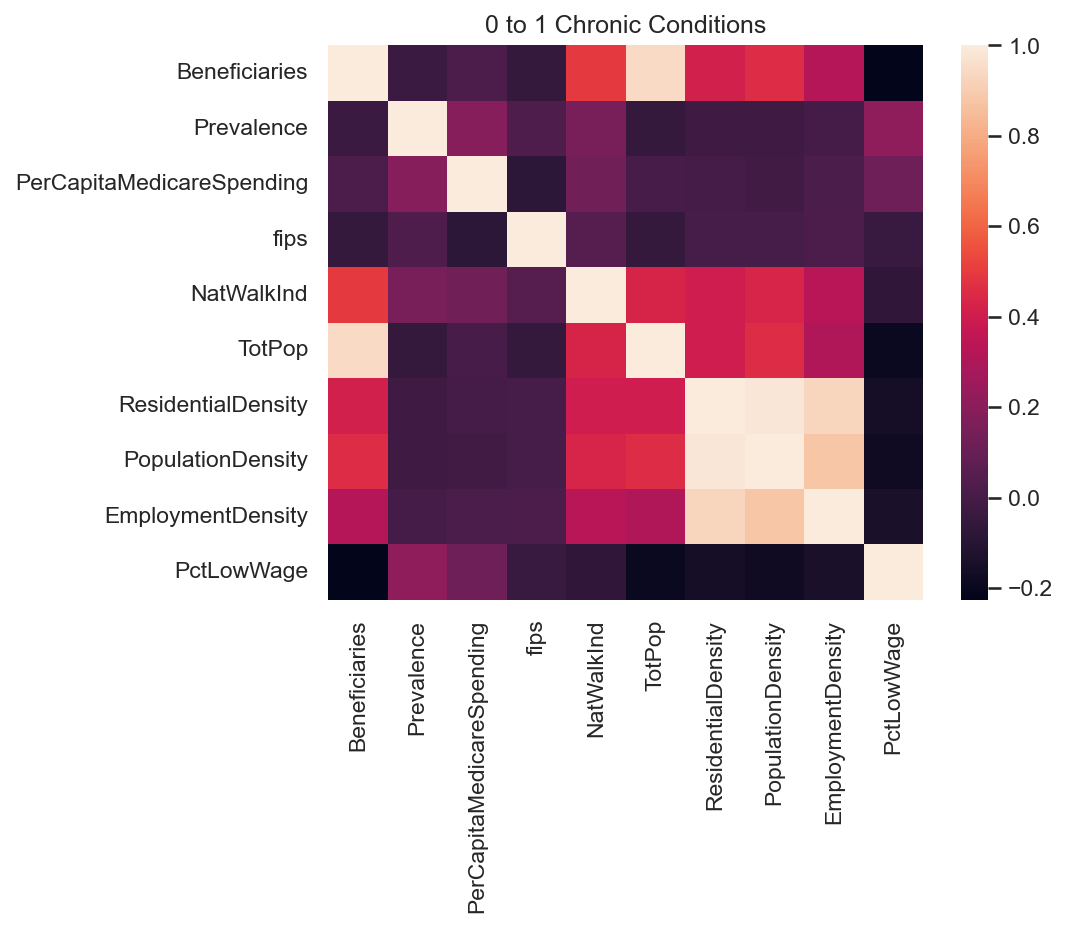

In [85]:
zero_one = spending_walkability[spending_walkability['ChronicConditionAmount'] == '0 to 1']
sns.heatmap(zero_one.corr())
plt.title('0 to 1 Chronic Conditions')

Text(0.5, 1.0, '0 to 1 Chronic Conditions')

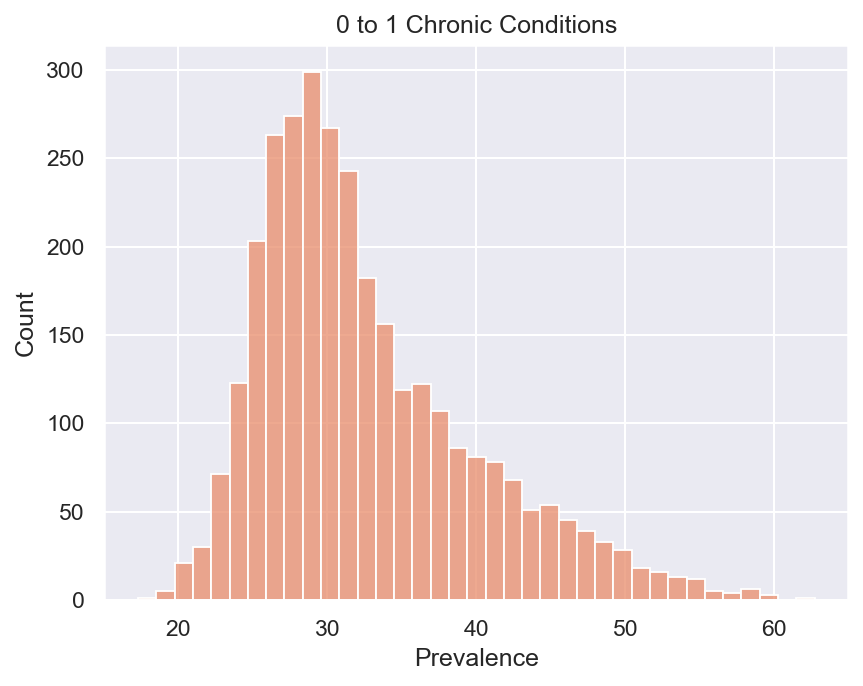

In [86]:
sns.histplot(zero_one, x='Prevalence')
plt.title('0 to 1 Chronic Conditions')

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\1992812003.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(two_three.corr())


Text(0.5, 1.0, '2 to 3 Chronic Conditions')

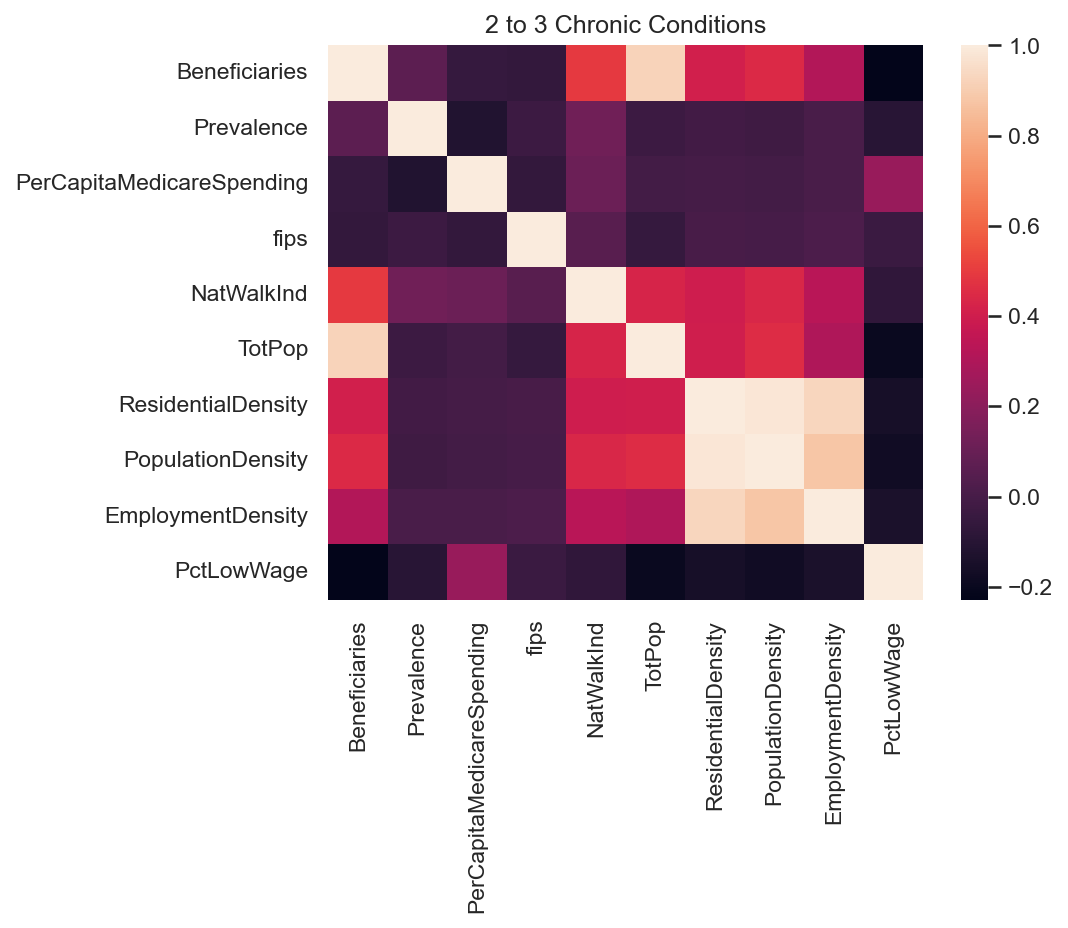

In [87]:
two_three = spending_walkability[spending_walkability['ChronicConditionAmount'] == '2 to 3']
sns.heatmap(two_three.corr())
plt.title('2 to 3 Chronic Conditions')

Text(0.5, 1.0, '2 to 3 Chronic Conditions')

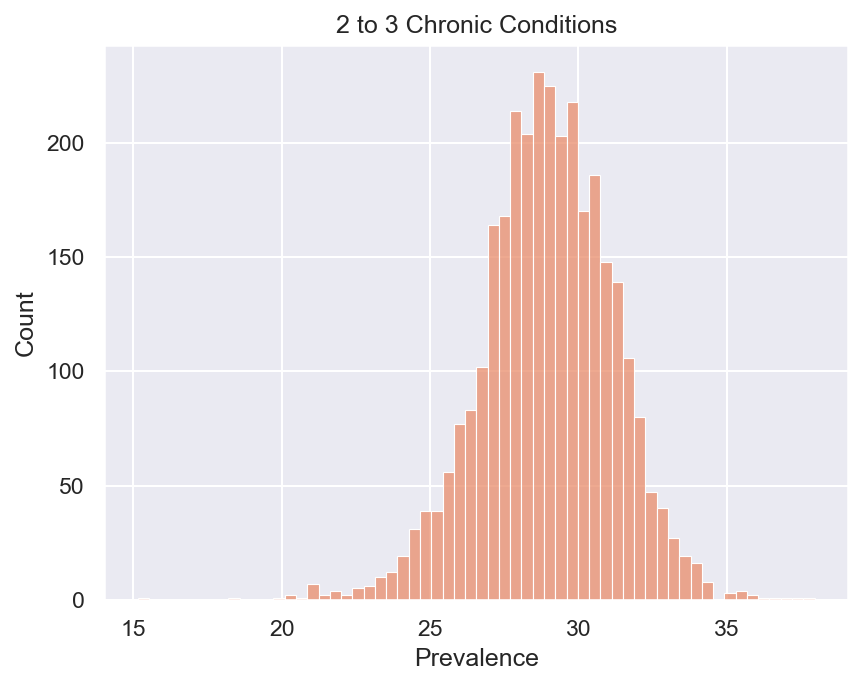

In [88]:
sns.histplot(two_three, x='Prevalence')
plt.title('2 to 3 Chronic Conditions')

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\656011459.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(four_five.corr())


Text(0.5, 1.0, '4 to 5 Chronic Conditions')

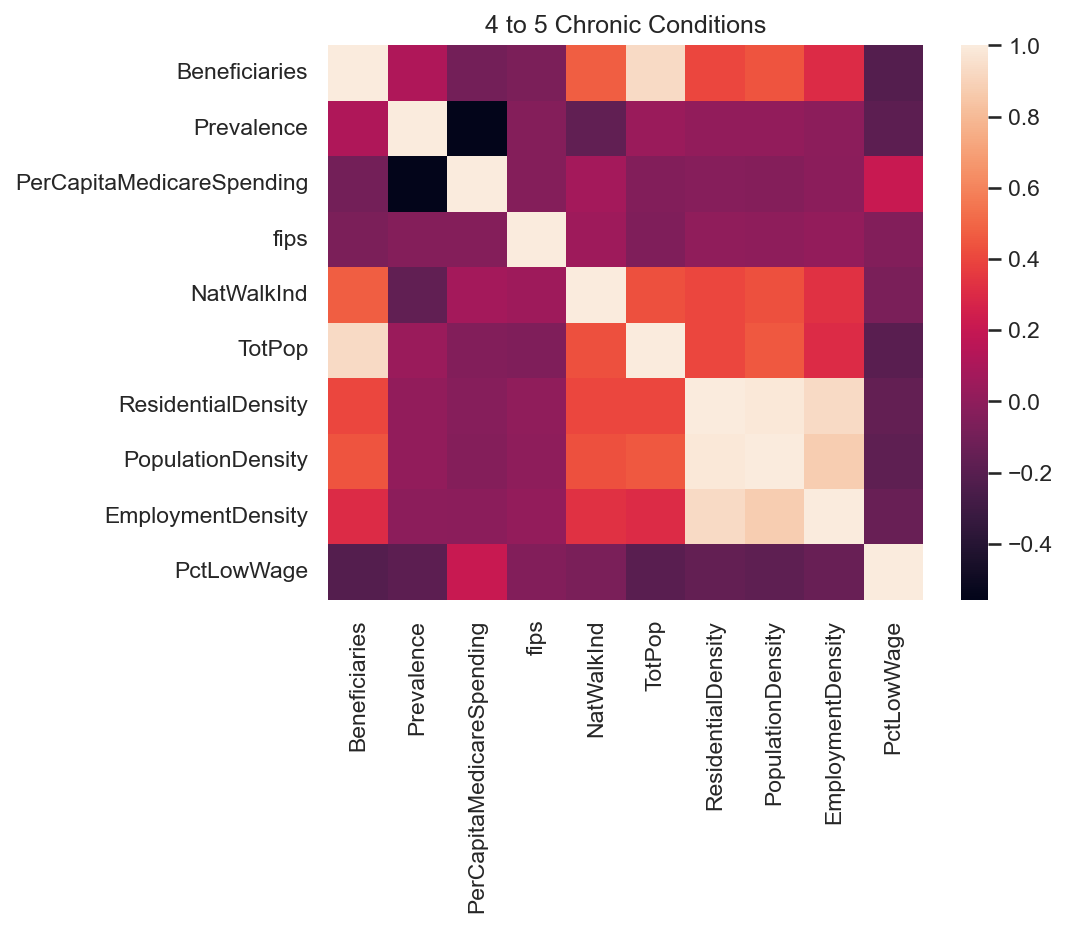

In [89]:
four_five = spending_walkability[spending_walkability['ChronicConditionAmount'] == '4 to 5']
sns.heatmap(four_five.corr())
plt.title('4 to 5 Chronic Conditions')

Text(0.5, 1.0, '4 to 5 Chronic Conditions')

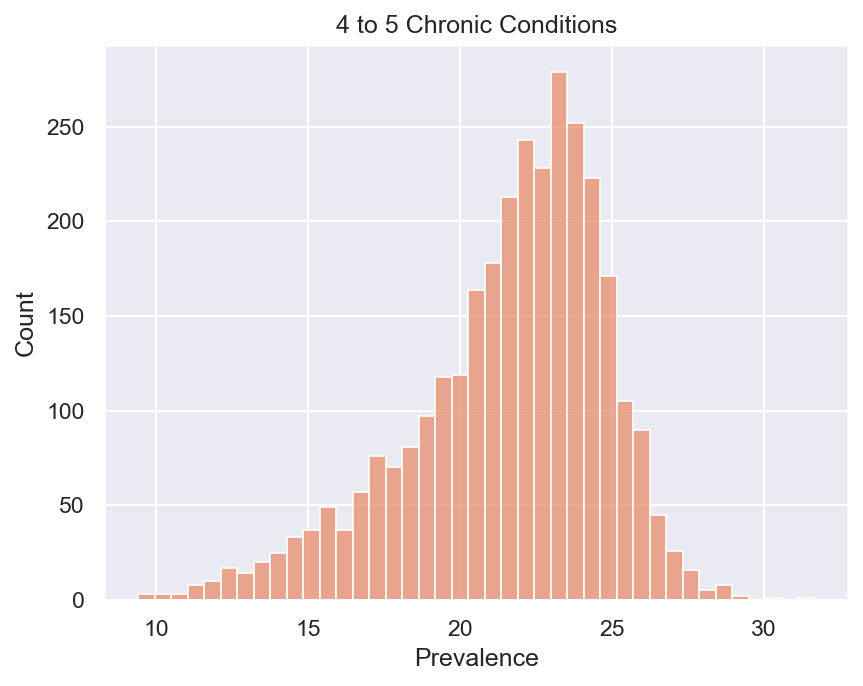

In [90]:
sns.histplot(four_five, x='Prevalence')
plt.title('4 to 5 Chronic Conditions')

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\2170116508.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(six_plus.corr())


Text(0.5, 1.0, '6+ Chronic Conditions')

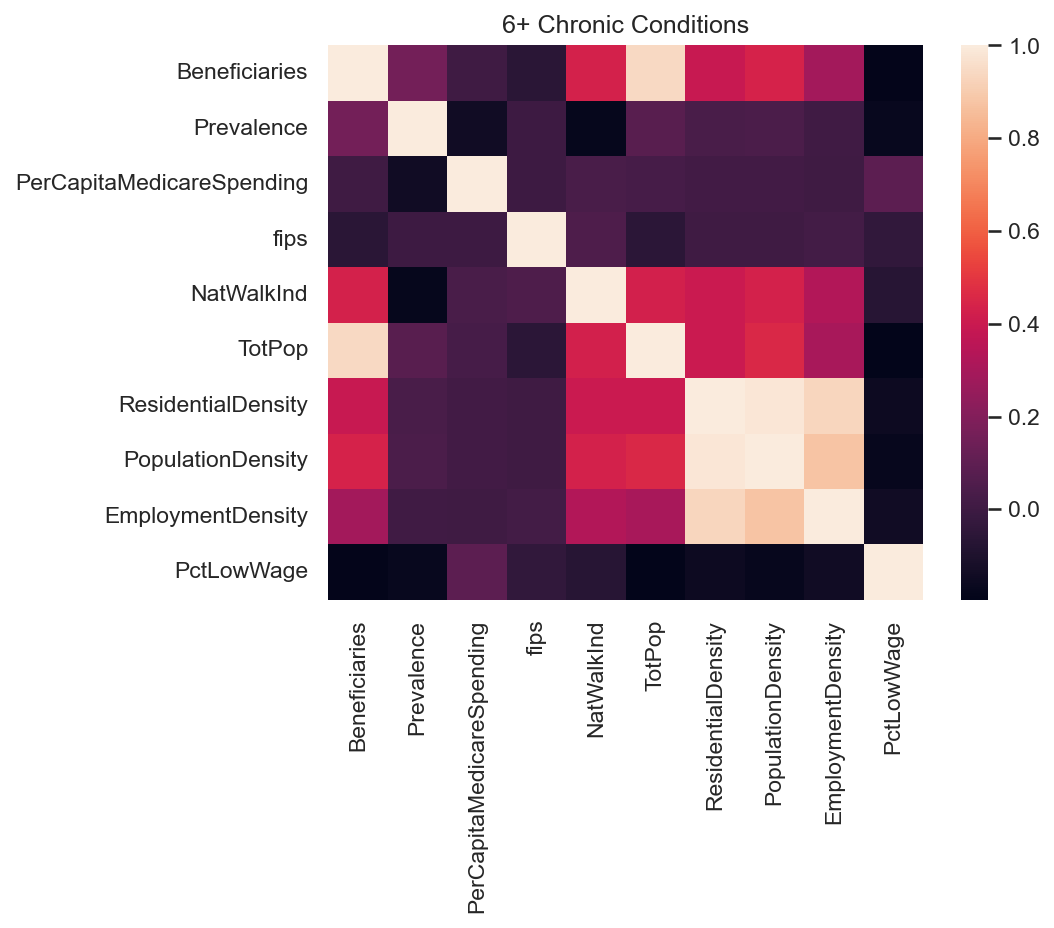

In [91]:
six_plus = spending_walkability[spending_walkability['ChronicConditionAmount'] == '6+']
sns.heatmap(six_plus.corr())
plt.title('6+ Chronic Conditions')

Text(0.5, 1.0, '6+ Chronic Conditions')

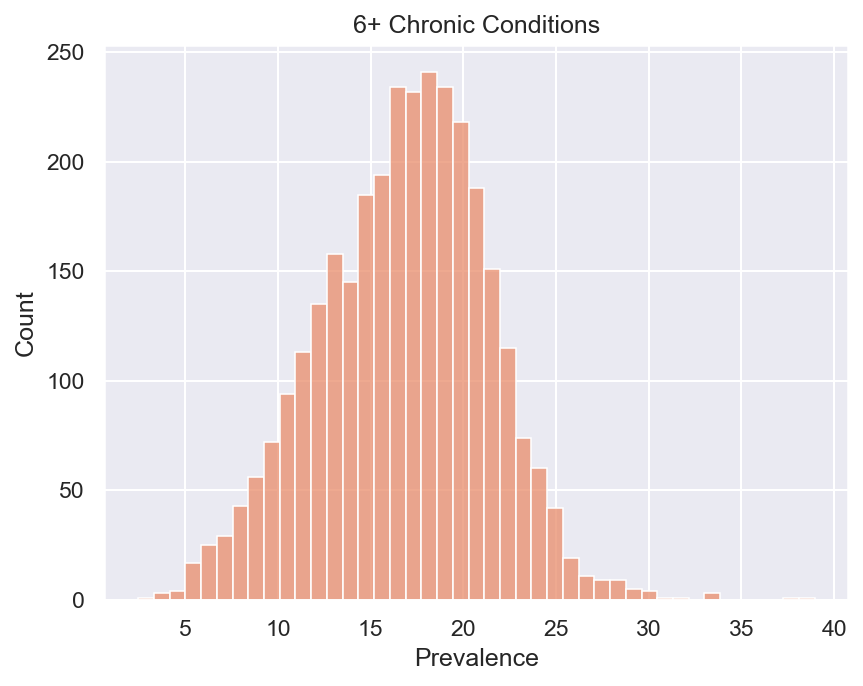

In [92]:
sns.histplot(six_plus, x='Prevalence')
plt.title('6+ Chronic Conditions')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Alcohol Abuse'),
  Text(1, 0, "Alzheimer's Disease/Dementia"),
  Text(2, 0, 'Arthritis'),
  Text(3, 0, 'Asthma'),
  Text(4, 0, 'Atrial Fibrillation'),
  Text(5, 0, 'COPD'),
  Text(6, 0, 'Cancer'),
  Text(7, 0, 'Chronic Kidney Disease'),
  Text(8, 0, 'Depression'),
  Text(9, 0, 'Diabetes'),
  Text(10, 0, 'Drug/Substance Abuse'),
  Text(11, 0, 'HIV/AIDS'),
  Text(12, 0, 'Heart Failure'),
  Text(13, 0, 'Hepatitis (Chronic Viral B & C)'),
  Text(14, 0, 'Hyperlipidemia'),
  Text(15, 0, 'Hypertension'),
  Text(16, 0, 'Ischemic Heart Disease'),
  Text(17, 0, 'Osteoporosis'),
  Text(18, 0, 'Schizophrenia and Other Psychotic Disorders'),
  Text(19, 0, 'Stroke'),
  Text(20, 0, 'Autism Spectrum Disorders')])

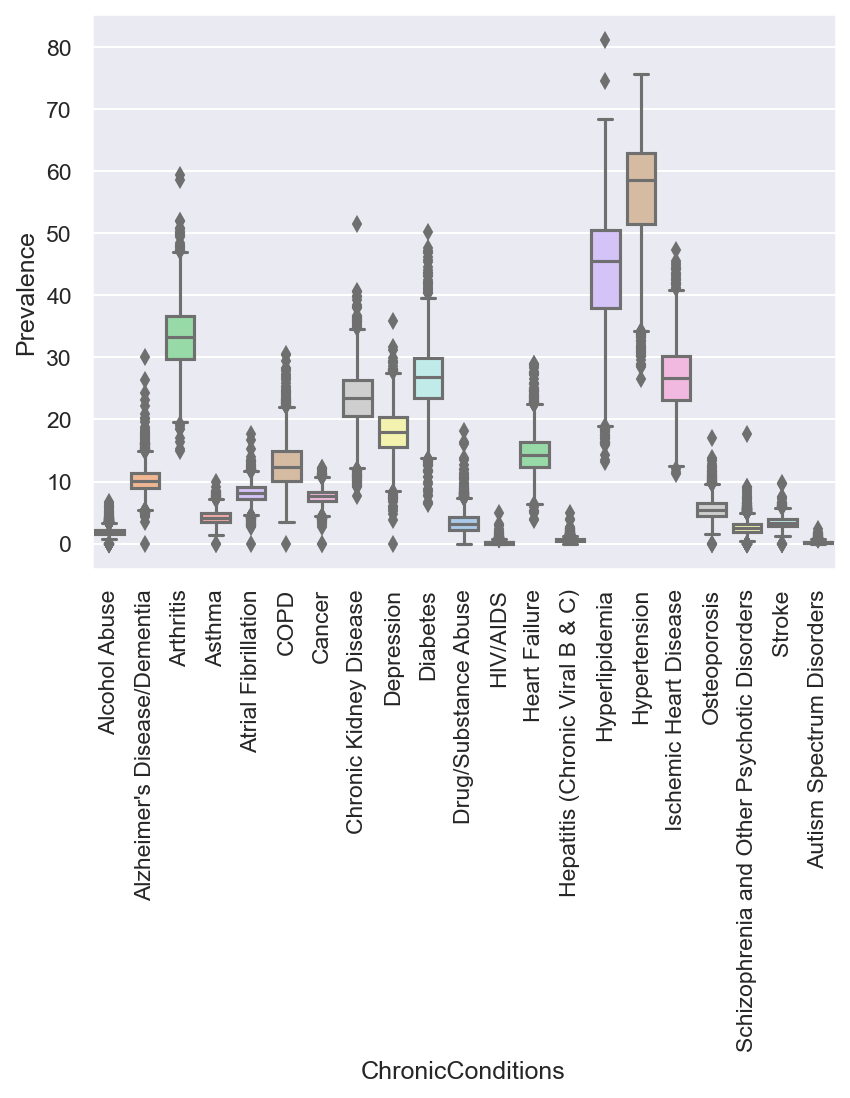

In [93]:
sns.boxplot(prevalence, y='Prevalence', x='ChronicConditions', palette='pastel')
plt.xticks(rotation=90)

In [94]:
## Ordinal Encoding for Chronic Conditions
ordinal_map = {
    '0 to 1': 0.5,
    '2 to 3': 2.5,
    '4 to 5': 4.5,
    '6+': 7
}

spending.iloc[:, 2] = spending.iloc[:, 2].map(ordinal_map)

C:\Users\Renzo Espinoza\AppData\Local\Temp\ipykernel_14300\3104156948.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  spending.iloc[:, 2] = spending.iloc[:, 2].map(ordinal_map)


In [95]:
spending_walkability = pd.merge(spending, walkability, how='left', left_on=['State', 'County'], right_on=['State', 'County'])

In [96]:
spending_walkability

,State,County,ChronicConditionAmount,Beneficiaries,Prevalence,PerCapitaMedicareSpending,fips,NatWalkInd,TotPop,ResidentialDensity,PopulationDensity,EmploymentDensity,PctLowWage
0,AL,Autauga,0.5,1338,26.58,2205.6662,1001,4.666667,55200,0.263939,0.628581,0.076586,0.230803
1,AL,Autauga,2.5,1416,28.13,5553.1539,1001,4.666667,55200,0.263939,0.628581,0.076586,0.230803
2,AL,Autauga,4.5,1249,24.81,10424.6752,1001,4.666667,55200,0.263939,0.628581,0.076586,0.230803
3,AL,Autauga,7.0,1031,20.48,27300.1283,1001,4.666667,55200,0.263939,0.628581,0.076586,0.230803
4,AL,Baldwin,0.5,7222,27.66,2205.9072,1003,6.250000,208107,0.334766,0.605024,0.110535,0.242640
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12503,WY,Washakie,7.0,175,9.92,40937.0233,56043,7.333333,8129,0.597772,1.507934,0.485411,0.260915
12504,WY,Weston,0.5,663,46.56,1995.1567,56045,5.666667,7100,0.039457,0.093379,0.015009,0.240944
12505,WY,Weston,2.5,390,27.39,7390.8903,56045,5.666667,7100,0.039457,0.093379,0.015009,0.240944
12506,WY,Weston,4.5,242,16.99,13631.4736,56045,5.666667,7100,0.039457,0.093379,0.015009,0.240944


In [97]:
zero_one_corr = pearsonr(zero_one.Prevalence, zero_one.NatWalkInd)
print(zero_one_corr)

PearsonRResult(statistic=0.14817205060431388, pvalue=8.193064222320187e-17)


In [98]:
two_three_corr = pearsonr(two_three.Prevalence, two_three.NatWalkInd)
print(two_three_corr)

PearsonRResult(statistic=0.12223138661671132, pvalue=6.977029169201466e-12)


In [99]:
four_five_corr = pearsonr(four_five.Prevalence, four_five.NatWalkInd)
print(four_five_corr)

PearsonRResult(statistic=-0.16592630554493776, pvalue=9.667160074549296e-21)


In [100]:
six_plus_corr = pearsonr(six_plus.Prevalence, six_plus.NatWalkInd)
print(six_plus_corr)

PearsonRResult(statistic=-0.17853833417938295, pvalue=8.238329459688021e-24)


In [101]:
# Kruskal-Wallis Test
kruskal(zero_one.Prevalence, two_three.Prevalence, four_five.Prevalence, six_plus.Prevalence)

KruskalResult(statistic=9252.142133476069, pvalue=0.0)

#### The high test statistic and a p-value of 0.0 confirms that there are statistically significant differences in the prevalence of different amounts of concurrent chronic conditions

In [102]:
X = spending_walkability[['ChronicConditionAmount', 'NatWalkInd']]
X = sm.add_constant(X)
y = spending_walkability.Prevalence

In [103]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prevalence   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:20:53   Log-Likelihood:                -37364.
No. Observations:               12508   AIC:                         7.473e+04
Df Residuals:                   12505   BIC:                         7.476e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     34.2237      0.142    241.178      0.000      33.946      34.502
ChronicConditionAmount    -2.5444      0.018   -142.772      0.000      -2.579      -2.510
NatWalkInd             -1.138e-05      0.019     -0.001      1.000      -0.037       0.037
==============================================================================
Omnibus:                     1644.090   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4937.984
Skew:                           0.696   Prob(JB):                         0.00
Kurtosis:                       5.745   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""